### IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array


### IMPORT / VIEWING / PREPROCESSING DATASET

> `DATA AUGMENTATION`

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [3]:

import os
os.chdir('C:/Users/91948/Documents/1.Sem 6/1.DeepLearning/Alzheimer_s Dataset/train')

In [4]:
train_dataset  = train_datagen.flow_from_directory(directory = 'C:/Users/91948/Documents/1.Sem 6/1.DeepLearning/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 4098 images belonging to 4 classes.


In [5]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'C:/Users/91948/Documents/1.Sem 6/1.DeepLearning/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 1023 images belonging to 4 classes.


### MODEL BUILDING

In [7]:
# Model Initialization

base_model = DenseNet169(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet") 

In [8]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [9]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [10]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 7, 7, 1664)        0         
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 batch_normalization (BatchN  (None, 81536)            326144    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              166987776 
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                        

In [11]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [12]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [13]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 8,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/8
33/33 [==============================] - ETA: 0s - loss: 1.2820 - auc: 0.7981 
Epoch 1: val_auc improved from -inf to 0.75996, saving model to .\best_weights.hdf5
33/33 [==============================] - 805s 24s/step - loss: 1.2820 - auc: 0.7981 - val_loss: 4.2721 - val_auc: 0.7600
Epoch 2/8
33/33 [==============================] - ETA: 0s - loss: 1.0847 - auc: 0.8337 
Epoch 2: val_auc did not improve from 0.75996
33/33 [==============================] - 768s 23s/step - loss: 1.0847 - auc: 0.8337 - val_loss: 3.4859 - val_auc: 0.6960
Epoch 3/8
33/33 [==============================] - ETA: 0s - loss: 0.9745 - auc: 0.8541 
Epoch 3: val_auc did not improve from 0.75996
33/33 [==============================] - 765s 23s/step - loss: 0.9745 - auc: 0.8541 - val_loss: 1.7915 - val_auc: 0.7574
Epoch 4/8
33/33 [==============================] - ETA: 0s - loss: 0.9077 - auc: 0.8666 
Epoch 4: val_auc improved from 0.75996 to 0.77647, saving model to .\best_weights.hdf5
33/33 [===========

### MODEL EVALUATION

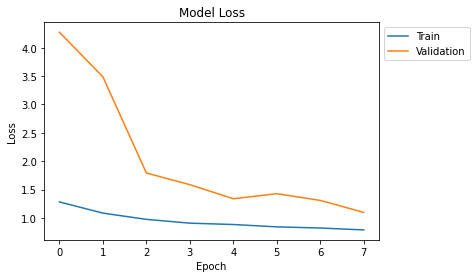

In [14]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

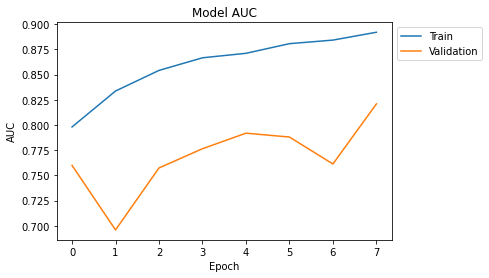

In [15]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [16]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = 'C:/Users/91948/Documents/1.Sem 6/1.DeepLearning/Alzheimer_s Dataset/test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)

Found 1279 images belonging to 4 classes.


In [17]:
# Evaluating Loss and AUC

model.evaluate(test_dataset)

10/10 [==============================] - 164s 16s/step - loss: 0.9304 - auc: 0.8718


[0.9303953051567078, 0.8718448877334595]

1/1 [==============================] - 0s 351ms/step
92.15 % chances are there that the image is NonDemented


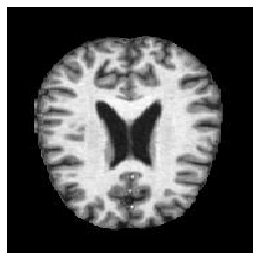

In [29]:
# Test Case 1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('C:/Users/91948/Documents/1.Sem 6/1.DeepLearning/Alzheimer_s Dataset/test/NonDemented/26 (100).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = (model.predict(img) > 0.5).astype("int32")

probability = round(np.max(model.predict(img)*100),2)

print(probability, '% chances are there that the image is',idc[np.argmax(answer[0])])

1/1 [==============================] - 0s 338ms/step
96.99 % chances are there that the image is VeryMildDemented


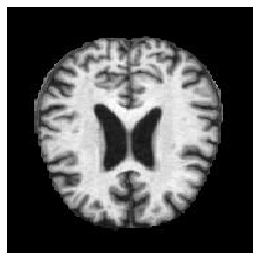

In [50]:
# Test Case 2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('C:/Users/91948/Documents/1.Sem 6/1.DeepLearning/Alzheimer_s Dataset/test/MildDemented/27 (16).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = (model.predict(img) > 0.5).astype("int32")

probability = round(np.max(model.predict(img)*100),2)

print(probability, '% chances are there that the image is',idc[np.argmax(answer[0])])

1/1 [==============================] - 0s 358ms/step
83.66 % chances are there that the image is VeryMildDemented


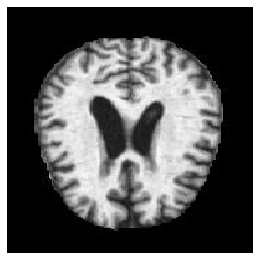

In [43]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('C:/Users/91948/Documents/1.Sem 6/1.DeepLearning/Alzheimer_s Dataset/test/ModerateDemented/27.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = (model.predict(img) > 0.5).astype("int32")
probability = round(np.max(model.predict(img)*100),2)

print(probability, '% chances are there that the image is',idc[np.argmax(answer[0])])

1/1 [==============================] - 0s 351ms/step
95.08 % chances are there that the image is VeryMildDemented


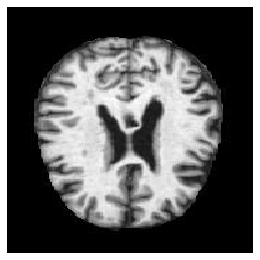

In [45]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('C:/Users/91948/Documents/1.Sem 6/1.DeepLearning/Alzheimer_s Dataset/test/VeryMildDemented/26 (45).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = (model.predict(img) > 0.5).astype("int32")
probability = round(np.max(model.predict(img)*100),2)

print(probability, '% chances are there that the image is',idc[np.argmax(answer[0])])

Conclusion:

So, we have finally built are deep learning model using DenseNet162 transfer learning algorithm and acheived and AUC-90%.